In [1]:
library(dplyr)
library(ggplot2)
library(gridExtra)
library(ggpubr)
library(ggrepel)
library(reshape2)
library(corrplot)
library(pheatmap)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


corrplot 0.92 loaded



In [2]:
perfdf = read.csv('test_set_performance.csv')
head(perfdf)

,y_pred,y_true,celltypes,switch_names,fold
,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,-0.12688252,-0.2430744,Astro,chr6:AARS2:44299560:44300312:-,fold_0
2,-0.17042626,0.4636032,Astro,chr17:ACADVL:7222082:7225225:+,fold_0
3,0.35755867,-0.1041806,Astro,chr1:ACP6:147647368:147649817:-,fold_0
4,-0.50502650,0.4364501,Astro,chr1:ACP6:147649817:147659061:-,fold_0
5,-0.94800365,-0.6193004,Astro,chr15:ACSBG1:78169717:78170845:-,fold_0
6,0.04431169,0.6421100,Astro,chr17:ACSF2:50427771:50474836:+,fold_0


In [3]:
table(perfdf$celltypes)


    Astro  Exc_deep   Exc_int Exc_upper       Inh Microglia     Oligo       OPC 
     5789      4561      4250      6851      8217      5755      5681      6200 

In [4]:
library(boot)

In [5]:
data = perfdf

In [6]:
# Define the correlation function for bootstrapping
correlation_function <- function(data, indices) {
  d <- data[indices, ]  # Allows boot to select sample
  return(cor(d$y_true, d$y_pred))
}

# Bootstrapping
set.seed(123)  # For reproducibility
bootstrap_results <- boot(data=data, statistic=correlation_function, R=1000)

# Calculate the overall correlation and its confidence interval
overall_correlation <- cor(data$y_true, data$y_pred)
confidence_interval <- boot.ci(bootstrap_results, type="perc")$percent[4:5]

# Calculate the p-value
p_value <- cor.test(data$y_true, data$y_pred)$p.value

# Print results
cat("Correlation: ", overall_correlation, "\n")
cat("95% Confidence Interval: (", confidence_interval[1], ", ", confidence_interval[2], ")\n")
cat("p-value: ", p_value, "\n")

Correlation:  0.5854367 
95% Confidence Interval: ( 0.5792364 ,  0.5920658 )
p-value:  0 


`geom_smooth()` using formula 'y ~ x'



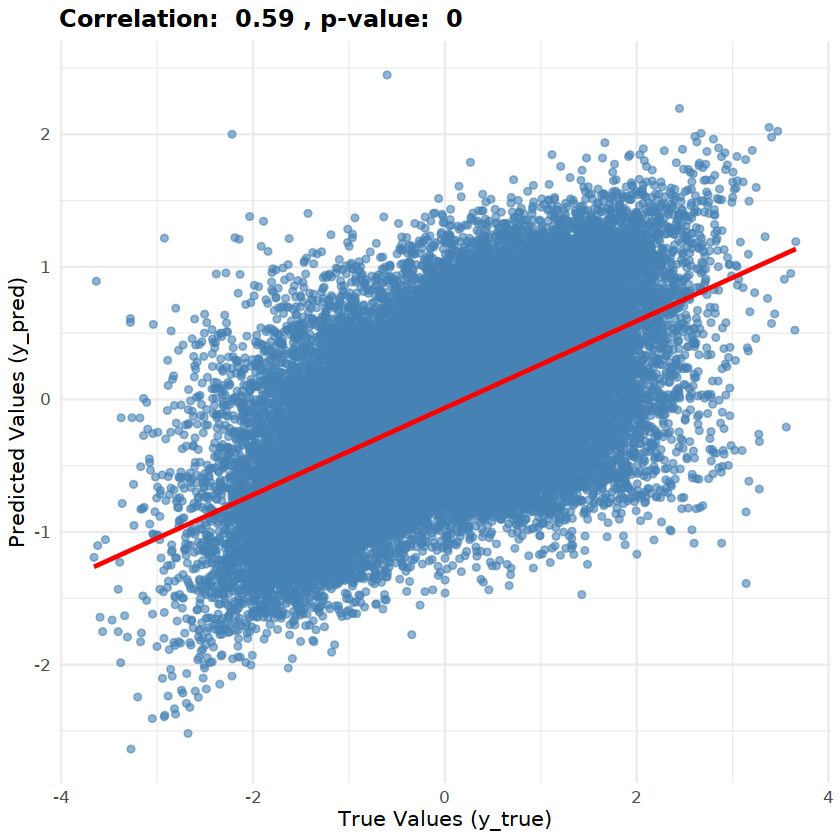

In [7]:
# Plotting
ggplot(data, aes(x=y_true, y=y_pred)) +
  geom_point(alpha=0.6, color="steelblue") +
  geom_smooth(method=lm, se=TRUE, color="red") +
  labs(
    title=paste("Correlation: ", round(overall_correlation, 2), ", p-value: ", round(p_value, 4)),
    x="True Values (y_true)",
    y="Predicted Values (y_pred)"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size=14, face="bold"),
    axis.title = element_text(size=12),
    axis.text = element_text(size=10)
  )

In [8]:
# Perform bootstrapping and calculate statistics for each cell type
bootstrap_results <- data %>%
  group_by(celltypes) %>%
  do({
    cor_val <- cor(.$y_true, .$y_pred)
    p_val <- cor.test(.$y_true, .$y_pred)$p.value
    boot_out <- boot(data=., statistic=correlation_function, R=1000)
    conf_int <- boot.ci(boot_out, type="perc")$percent[4:5]
    data.frame(correlation=cor_val, p_value=p_val, conf_lower=conf_int[1], conf_upper=conf_int[2])
  })

# Print results
print(bootstrap_results)

# A tibble: 8 × 5
# Groups:   celltypes [8]
  celltypes correlation p_value conf_lower conf_upper
  <chr>           <dbl>   <dbl>      <dbl>      <dbl>
1 Astro           0.586       0      0.567      0.606
2 Exc_deep        0.561       0      0.538      0.583
3 Exc_int         0.588       0      0.567      0.611
4 Exc_upper       0.597       0      0.579      0.614
5 Inh             0.558       0      0.542      0.574
6 Microglia       0.666       0      0.648      0.681
7 Oligo           0.562       0      0.540      0.582
8 OPC             0.582       0      0.561      0.601


In [10]:
colors <- c(
  Oligo = '#da8bc3',
  OPC = '#937860', 
  Astro = '#4c72b0',
  Microglia = '#8c8c8c',
  Exc_upper = '#8172b3',
  Exc_int = '#c44e52', 
  Exc_deep = '#55a868', 
  Inh = '#dd8452'
)

In [11]:
bootstrap_results

celltypes,correlation,p_value,conf_lower,conf_upper
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Astro,0.5856830,0,0.5671082,0.6063433
Exc_deep,0.5612310,0,0.5381239,0.5830421
Exc_int,0.5880615,0,0.5671069,0.6108470
Exc_upper,0.5970319,0,0.5790644,0.6143778
Inh,0.5576900,0,0.5416318,0.5744946
Microglia,0.6656641,0,0.6476350,0.6812780
Oligo,0.5615490,0,0.5401087,0.5819252
OPC,0.5822276,0,0.5612017,0.6009778


In [12]:
bootstrap_results$celltypes <- factor(bootstrap_results$celltypes, levels = names(colors))
bootstrap_results$color <- colors[bootstrap_results$celltypes]
bootstrap_results

celltypes,correlation,p_value,conf_lower,conf_upper,color
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Astro,0.5856830,0,0.5671082,0.6063433,#4c72b0
Exc_deep,0.5612310,0,0.5381239,0.5830421,#55a868
Exc_int,0.5880615,0,0.5671069,0.6108470,#c44e52
Exc_upper,0.5970319,0,0.5790644,0.6143778,#8172b3
Inh,0.5576900,0,0.5416318,0.5744946,#dd8452
Microglia,0.6656641,0,0.6476350,0.6812780,#8c8c8c
Oligo,0.5615490,0,0.5401087,0.5819252,#da8bc3
OPC,0.5822276,0,0.5612017,0.6009778,#937860


In [13]:
# Plot with points and error bars
plt <- ggplot(bootstrap_results, aes(x=celltypes, y=correlation, color=celltypes)) +
  geom_point(size=4) +
  geom_errorbar(aes(ymin=conf_lower, ymax=conf_upper), size=1, width=0.5) +
  scale_color_manual(values=colors) +
  labs(
    title="Correlation of True vs. Predicted Values by Cell Type",
    x="Cell Type",
    y="Median Correlation"
  ) +
  ylim(0.5, 0.7) +
  # ylim(0.4,.7) +
  theme_minimal() +
  theme(
    plot.title = element_text(size=14, face="bold"),
    axis.title = element_text(size=12),
    axis.text = element_text(size=10),
    legend.position = "none",
    axis.line = element_line(color="black"),
    # no grid
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
  ) 
  # geom_text(aes(label=sprintf("%.3f", correlation)), vjust=-1.5, hjust=-0.5, size=5)

## ggsave pdf
ggsave("correlation_by_celltype.pdf", plt, width=5, height=3)

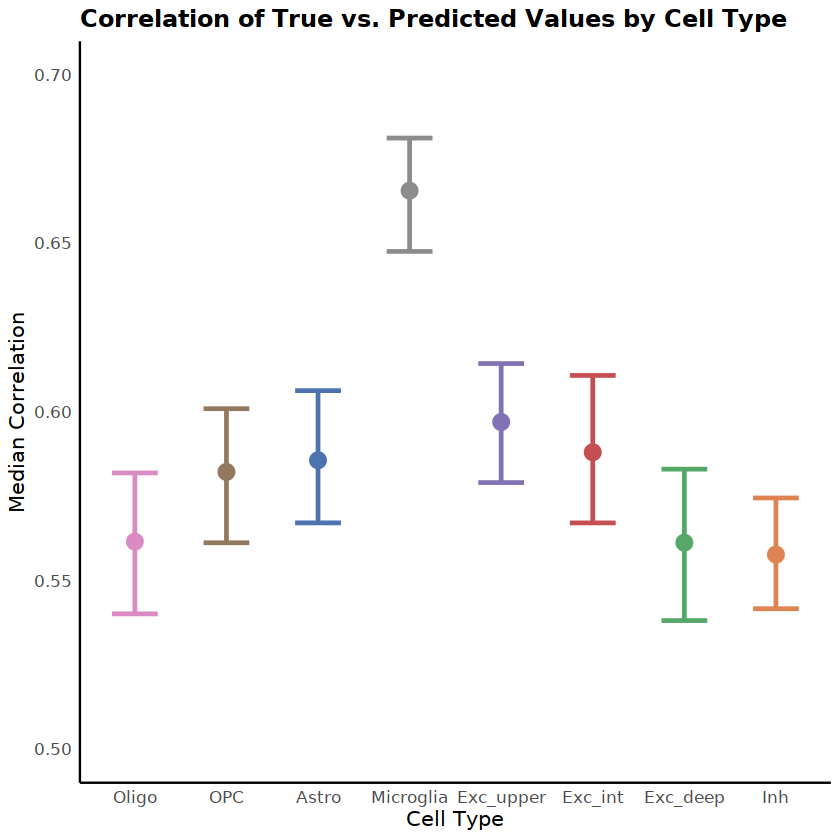

In [14]:
plt